In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gsw
from matplotlib.ticker import MaxNLocator

import cartopy as cart
import cartopy.crs as ccrs
import cmocean.cm as cmo
import seaborn as sns
from glob import glob
import cartopy.feature as cfeature

In [2]:
sim = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/backtrack_SA/SA_5179m_t3650_diff-False.nc')

In [3]:
sim

<xarray.Dataset>
Dimensions:           (traj: 50000, obs: 3651)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory        (traj, obs) float64 0.0 0.0 0.0 0.0 ... 5e+04 5e+04 5e+04
    time              (traj, obs) datetime64[ns] 2019-12-30T12:00:00 ... 2010...
    lat               (traj, obs) float64 -32.15 -32.12 -32.08 ... -33.73 -33.74
    lon               (traj, obs) float64 6.295 6.353 6.37 ... -0.2144 -0.2338
    z                 (traj, obs) float64 5.179e+03 5.185e+03 ... 4.293e+03
    cons_temperature  (traj, obs) float32 0.7166 0.7281 0.7275 ... 0.7073 0.7133
    abs_salinity      (traj, obs) float32 34.74 34.74 34.74 ... 34.74 34.74
    mld               (traj, obs) float32 33.11 50.49 50.82 ... 17.87 10.74
    alpha             (traj, obs) float32 1e-06 1e-06 1e-06 ... 1e-06 1e-06
    density           (traj, obs) float32 1.035e+03 1.028e+03 ... 1.028e+03
    v_s               (traj, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.0-71-g202ef087
    parcels_mesh:           spherical

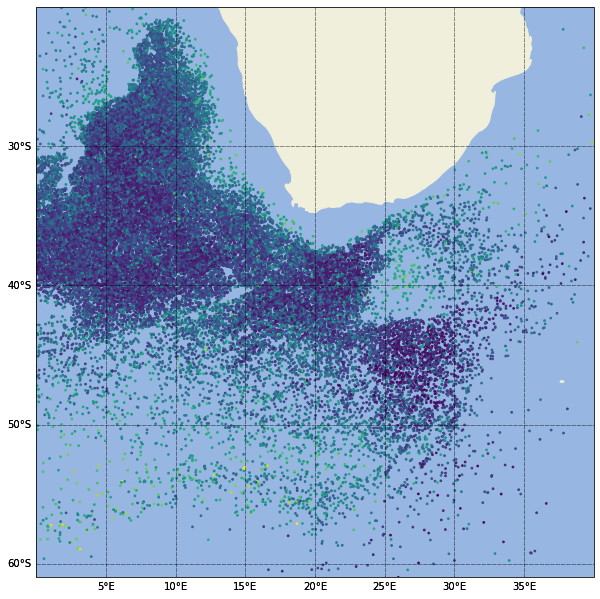

In [4]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
# ax.add_feature(cfeature.COASTLINE)

n = 3600
ax.scatter(sim['lon'][:, n], sim['lat'][:, n], c=-sim['z'][:, n], s=3)


# for i in range(3):
#     ax.scatter(posterior30['lon'][ilons[i]], posterior30['lat'][ilats[i]], 
#                s=60, marker='o', color='red', edgecolors='k')
#     ax.text(posterior30['lon'][ilons[i]]+2, posterior30['lat'][ilats[i]]+2, labels[i], fontsize=14)

In [6]:
def find_badparticle(dataset, ref_field):
    a = dataset['trajectory'][:,0].where(dataset[ref_field][:,-1]<1).values
    _traj = np.int32(a[~np.isnan(a)])
    return _traj

In [7]:
find_badparticle(sim, 'abs_salinity')

array([    1,     4,    10, ..., 49979, 49983, 49998], dtype=int32)

In [8]:
a = sim['trajectory'][:,0].where(sim['abs_salinity'][:,2000]<1).values

In [9]:
weird_traj = np.int32(a[~np.isnan(a)])

In [14]:
sim['lon'][weird_traj[0:5], 0]

<xarray.DataArray 'lon' (traj: 5)>
array([6.30312835, 6.28702691, 6.27152917, 6.30336548, 6.30242295])
Dimensions without coordinates: traj
Attributes:
    long_name:      
    standard_name:  longitude
    units:          degrees_east
    axis:           X

In [37]:
time_dim = 3651

sal_under_1 = np.zeros(time_dim)
temp_under_1 = np.zeros(time_dim)
stuck = np.zeros(time_dim)
# _temp = np.zeros(time_dim)
no_movement = np.diff(sim['lon'], axis=1)

for t in range(time_dim-1):
    sal_under_1[t] = (sim['abs_salinity'][:,t]<1).values.sum()
    temp_under_1[t] = (sim['cons_temperature'][:,t]<=0).values.sum()
#     _temp = (sim['cons_temperature'][:,t]<0).values.sum()
    stuck[t] = (no_movement[:, t] == 0).sum()

Text(0, 0.5, 'Number of particles')

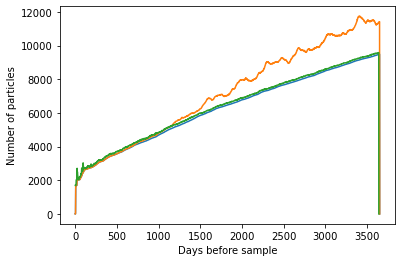

In [38]:
plt.plot(sal_under_1)
plt.plot(temp_under_1)
plt.plot(stuck[10:])
plt.xlabel('Days before sample')
plt.ylabel('Number of particles')

In [39]:
time_dim = 3651

stuck_lon = np.zeros(time_dim)
stuck_lat = np.zeros(time_dim)
stuck_z = np.zeros(time_dim)

acc_lon = np.diff(sim['lon'], axis=1)
acc_lat = np.diff(sim['lat'], axis=1)
acc_z = np.diff(sim['z'], axis=1)

for t in range(time_dim-1):
    stuck_lon[t] = (acc_lon[:, t] == 0).sum()
    stuck_z[t] = (acc_z[:, t] == 0).sum()
    stuck_lat[t] = (acc_lat[:, t] == 0).sum()

Text(0, 0.5, 'Number of particles')

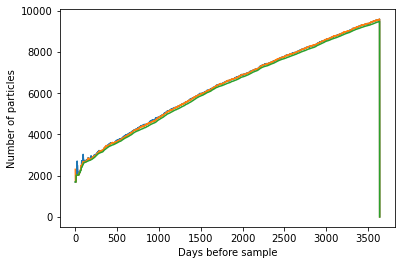

In [40]:
plt.plot(stuck_lon[10:])
plt.plot(stuck_lat[10:])
plt.plot(stuck_z[10:])
plt.xlabel('Days before sample')
plt.ylabel('Number of particles')

In [74]:
c = (acc_lon + acc_lat + acc_z)
c = ~(c == 0)

In [75]:
np.where(c == True)

(array([    0,     0,     0, ..., 49999, 49999, 49999]),
 array([   0,    1,    2, ..., 3647, 3648, 3649]))

In [153]:
def stuck_particles_mask(dataset):
    time = dataset.dims['obs']

    diff_lon = np.roll(dataset['lon'], axis=1, shift=1) - dataset['lon']
    diff_lat = np.roll(dataset['lat'], axis=1, shift=1) - dataset['lat']
    diff_z = np.roll(dataset['z'], axis=1, shift=1) - dataset['z']
    
    mask = (diff_lon + diff_lat + diff_z)
    mask = ~(mask == 0)
    
    return mask

In [133]:
msk = stuck_particles_mask(sim)

In [134]:
stuck_particles = 50000 - np.sum(msk, axis=0)

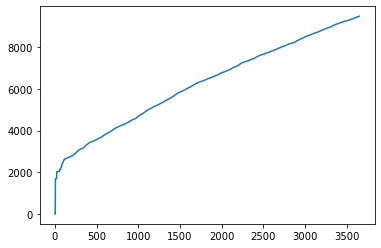

In [135]:
plt.plot(stuck_particles)

In [136]:
sim_masked = sim.where(msk == True)

In [137]:
(sim_masked['abs_salinity'] < 1).sum()

<xarray.DataArray 'abs_salinity' ()>
array(9490)

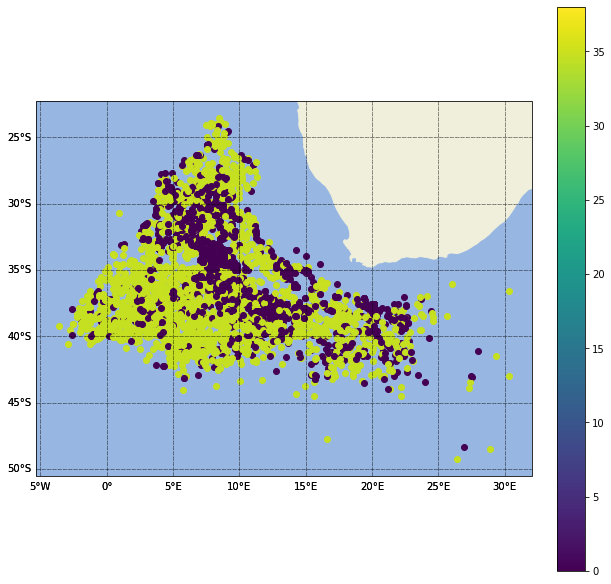

In [124]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
# ax.add_feature(cfeature.COASTLINE)

n = 1000
for i in weird_traj:
    im = ax.scatter(sim['lon'][i, n], sim['lat'][i,n], c=sim['abs_salinity'][i,n], vmin=0, vmax=38);

plt.colorbar(im)

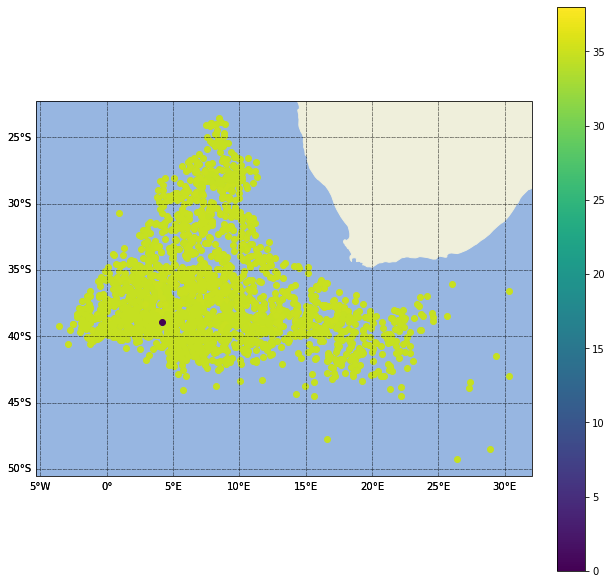

In [125]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
# ax.add_feature(cfeature.COASTLINE)

n = 1000
for i in weird_traj:
    im = ax.scatter(sim_masked['lon'][i, n], sim_masked['lat'][i,n], c=sim_masked['abs_salinity'][i,n], vmin=0, vmax=38);

plt.colorbar(im)

#### sim60

In [138]:
sim60 = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/backtrack_SA/SA_60m_t3650_diff-False.nc')

In [154]:
masked_60 = stuck_particles_mask(sim60)

In [155]:
sim60_masked = sim60.where(masked_60 == True)

In [149]:
w_idx = find_badparticle(sim60, 'abs_salinity')

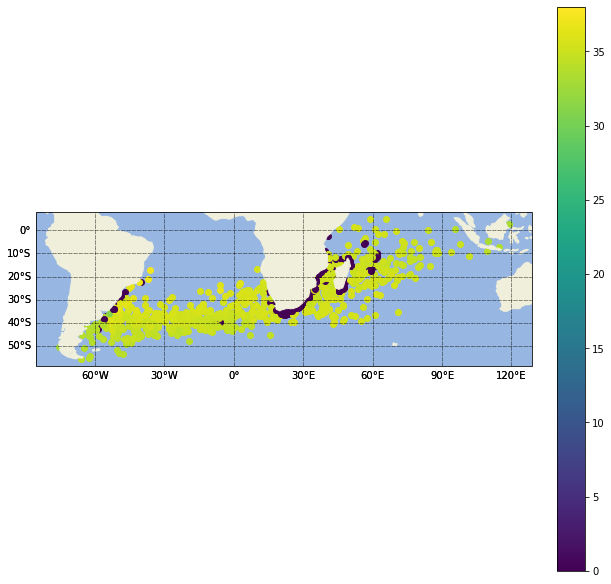

In [151]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
# ax.add_feature(cfeature.COASTLINE)

n = 1000
for i in w_idx:
    im = ax.scatter(sim60['lon'][i, n], sim60['lat'][i,n], c=sim60['abs_salinity'][i,n], vmin=0, vmax=38);

plt.colorbar(im)

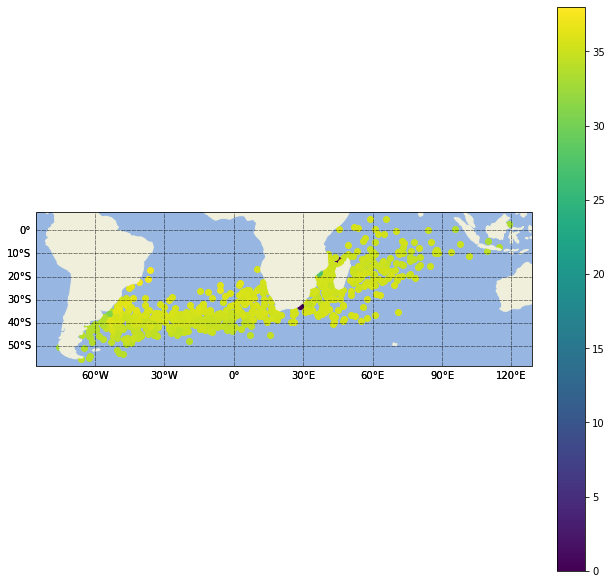

In [156]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
# ax.add_feature(cfeature.COASTLINE)

n = 1000
for i in w_idx:
    im = ax.scatter(sim60_masked['lon'][i, n], sim60_masked['lat'][i,n], c=sim60_masked['abs_salinity'][i,n], vmin=0, vmax=38);

plt.colorbar(im)